In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import glob

In [21]:
csv_files = glob.glob("data/raw/heart_rates/*.csv")
csv_files = [csv_file.replace("\\", "/") for csv_file in csv_files]

print(csv_files)

['data/raw/heart_rates/2024-12-21.csv', 'data/raw/heart_rates/2024-12-22.csv', 'data/raw/heart_rates/2024-12-23.csv', 'data/raw/heart_rates/2024-12-24.csv', 'data/raw/heart_rates/2024-12-25.csv', 'data/raw/heart_rates/2024-12-26.csv', 'data/raw/heart_rates/2024-12-27.csv', 'data/raw/heart_rates/2024-12-28.csv', 'data/raw/heart_rates/2024-12-29.csv', 'data/raw/heart_rates/2024-12-30.csv', 'data/raw/heart_rates/2024-12-31.csv', 'data/raw/heart_rates/2025-01-01.csv', 'data/raw/heart_rates/2025-01-02.csv']


In [22]:
all_data = pd.concat(
    (pd.read_csv(file).assign(date=file.split('/')[-1].replace('.csv', '')) for file in csv_files),
    ignore_index=True
)

In [23]:
all_data.head()

,timestamp,heart_rates,date
0,14:58,69.0,2024-12-21
1,15:00,70.0,2024-12-21
2,15:02,66.0,2024-12-21
3,15:04,71.0,2024-12-21
4,15:06,75.0,2024-12-21


In [24]:
all_data.tail()

,timestamp,heart_rates,date
8163,07:58,74.0,2025-01-02
8164,08:00,62.0,2025-01-02
8165,08:02,63.0,2025-01-02
8166,08:04,67.0,2025-01-02
8167,08:06,61.0,2025-01-02


In [25]:
all_data.dtypes

timestamp       object
heart_rates    float64
date            object
dtype: object

In [26]:
missing_values_counts = all_data.isna().sum()
missing_values_counts

timestamp       0
heart_rates    23
date            0
dtype: int64

In [27]:
df_shape_per_day = {}

for file in csv_files:
    day = file.split("/")[-1].replace('.csv', '')
    df = pd.read_csv(file)

    df_rows = df.shape[0]

    df_shape_per_day[day] = df_rows

print(df_shape_per_day)

{'2024-12-21': 241, '2024-12-22': 719, '2024-12-23': 720, '2024-12-24': 720, '2024-12-25': 584, '2024-12-26': 720, '2024-12-27': 648, '2024-12-28': 704, '2024-12-29': 720, '2024-12-30': 720, '2024-12-31': 720, '2025-01-01': 708, '2025-01-02': 244}


In [28]:
minutes_per_day = 24 * 60
expected_rows = (minutes_per_day / 2) * 0.9

print(f"Expected records for each day: {expected_rows}") 

Expected records for each day: 648.0


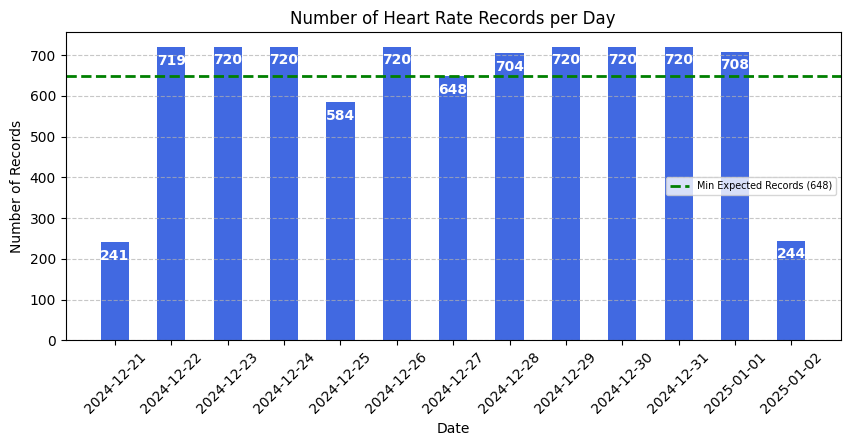

In [29]:
days = list(df_shape_per_day.keys())
rows = list(df_shape_per_day.values())

plt.figure(figsize=(10, 4))
bars = plt.bar(days, rows, color='royalblue', width=0.5)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval-50, str(int(yval)), 
            ha='center', va='bottom', fontsize=10, fontweight='bold', color='white')

plt.axhline(y=expected_rows, color='green', linestyle='--', linewidth=2, label=f'Min Expected Records ({int(expected_rows)})')

plt.xlabel('Date')
plt.ylabel('Number of Records')
plt.title('Number of Heart Rate Records per Day')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(fontsize='x-small')
plt.show()

In [30]:
upper_days = [day for day, rows in df_shape_per_day.items() if (rows > expected_rows and rows < (minutes_per_day / 2))]
lower_days = [day for day, rows in df_shape_per_day.items() if rows < expected_rows]

In [32]:
for day in upper_days:
    df = pd.read_csv(f"data/raw/heart_rates\\{day}.csv")
    df['timestamp'] = pd.to_datetime(df['timestamp'], format="%H:%M")
    df['timestamp'] = df['timestamp'].apply(lambda time: time.time())
    start_time, end_time = pd.to_datetime("00:00", format="%H:%M").time(), pd.to_datetime("23:58", format="%H:%M").time()
    
    expected_items = pd.timedelta_range(start="00:00:00", end="23:58:00", freq='2min')

